In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical  # Use this instead of np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.inspection import permutation_importance

In [2]:
data_time = pd.read_csv("Timedomain_Features_10s.csv")

In [3]:
data_time.drop(columns=['Unnamed: 0','Mean','Variance'])

,Max,Min,Range,Range_1,Sum,RMS,Std. Dev.,Kurtosis,Skewness,Crest Factor,Form Factor,Operation
0,0.721996,1.550000e-17,0.721996,1.423641,-34.946801,0.231820,0.136180,2.660088,-0.008122,3.114471,1.235679,Dumping
1,0.701645,1.550000e-17,0.701645,1.327309,-41.295125,0.221297,0.132232,2.806348,-0.016149,3.170603,1.247112,Dumping
2,0.721996,1.070000e-06,0.721995,1.383088,6.348324,0.241885,0.139281,2.522130,-0.003815,2.984870,1.223107,Dumping
3,0.721996,1.550000e-17,0.721996,1.423641,-37.460391,0.228547,0.135573,2.765011,0.001605,3.159066,1.242135,Dumping
4,0.661092,1.070000e-06,0.661091,1.282097,2.513590,0.239282,0.137222,2.442421,-0.028812,2.762819,1.220651,Dumping
...,...,...,...,...,...,...,...,...,...,...,...,...
17472,0.841699,4.510000e-18,0.841699,1.617447,-98.960683,0.204763,0.159089,6.487563,-0.467042,4.110601,1.588332,Loading
17473,0.604826,1.380000e-05,0.604812,1.073233,71.999216,0.242848,0.128148,2.116602,0.046170,2.490548,1.177202,Loading
17474,0.841699,4.510000e-18,0.841699,1.617447,-26.961467,0.211587,0.157032,5.377404,-0.327632,3.978024,1.492015,Loading
17475,0.841699,4.510000e-18,0.841699,1.617447,-26.961467,0.211587,0.157032,5.377404,-0.327632,3.978024,1.492015,Loading


In [4]:
# Assuming 'data_time' is DataFrame
data_time['Operation'] = pd.Categorical(data_time['Operation'])

In [5]:
# Splitting the data
train_data, test_data = train_test_split(data_time, test_size=750, stratify=data_time['Operation'], random_state=1234)

In [6]:
# Extracting features and target
X_train = train_data.iloc[:, 0:14].values  # Selecting columns 0 to 14 (features)
y_train = train_data['Operation'].values      # Selecting 'Operation' column (target)

X_test = test_data.iloc[:, 0:14].values    # Selecting columns 0 to 14 (features)
y_test = test_data['Operation'].values        # Selecting 'Operation' column (target)

In [7]:
# Encoding categorical target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [8]:
# One-hot encoding for Keras
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

In [9]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [10]:
# Initialize ANN
classifier = Sequential()

In [11]:
# Adding the input layer and first hidden layer
classifier.add(Dense(units=14, kernel_initializer='uniform', activation='relu', input_shape=(14,)))

# Adding the second hidden layer
classifier.add(Dense(units=14, kernel_initializer='uniform', activation='relu'))

# Adding the output layer
classifier.add(Dense(units=4, kernel_initializer='uniform', activation='softmax'))

# Summary of the model architecture
classifier.summary()

C:\Users\TEJOMAY\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 14)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              60 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 480 (1.88 KB)

 Trainable params: 480 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compiling the ANN
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Fit ANN to training set
classifier.fit(X_train, y_train_one_hot, batch_size=10, epochs=100, validation_data=(X_test, y_test_one_hot))

Epoch 1/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6194 - loss: 0.8829 - val_accuracy: 0.8547 - val_loss: 0.4567
Epoch 2/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8647 - loss: 0.4066 - val_accuracy: 0.8813 - val_loss: 0.3634
Epoch 3/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8837 - loss: 0.3331 - val_accuracy: 0.8893 - val_loss: 0.3246
Epoch 4/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8898 - loss: 0.3208 - val_accuracy: 0.8960 - val_loss: 0.3007
Epoch 5/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8933 - loss: 0.2945 - val_accuracy: 0.9000 - val_loss: 0.2919
Epoch 6/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8978 - loss: 0.2821 - val_accuracy: 0.9093 - val_loss: 0.2730
Epoch 7/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9005 - loss: 0.2732 - val_accuracy: 0.9120 - val_loss: 0.2768
Epoch 8/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9017 - loss: 0

1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9373 - loss: 0.1849 - val_accuracy: 0.9333 - val_loss: 0.2033
Epoch 51/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9372 - loss: 0.1811 - val_accuracy: 0.9493 - val_loss: 0.1774
Epoch 52/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9362 - loss: 0.1820 - val_accuracy: 0.9440 - val_loss: 0.1835
Epoch 53/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9338 - loss: 0.1883 - val_accuracy: 0.9480 - val_loss: 0.1920
Epoch 54/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9400 - loss: 0.1764 - val_accuracy: 0.9467 - val_loss: 0.1912
Epoch 55/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9369 - loss: 0.1763 - val_accuracy: 0.9453 - val_loss: 0.1749
Epoch 56/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9381 - loss: 0.1783 - val_accuracy: 0.9453 - val_loss: 0.1847
Epoch 57/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9368 - loss: 0.1762

1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9436 - loss: 0.1605 - val_accuracy: 0.9467 - val_loss: 0.1695
Epoch 100/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9405 - loss: 0.1692 - val_accuracy: 0.9493 - val_loss: 0.1706


In [14]:
# Evaluate the model
scores = classifier.evaluate(X_test, y_test_one_hot)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9478 - loss: 0.1660  
Test Accuracy: 94.93%


In [15]:
# Make predictions on the test set
y_pred_one_hot = classifier.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [16]:
# Convert one-hot encoded predictions to integer labels
y_pred = np.argmax(y_pred_one_hot, axis=1)
y_test_actual = np.argmax(y_test_one_hot, axis=1)

In [17]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_actual, y_pred)

In [18]:
# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[234   5   0   8]
 [  2 165   0   2]
 [  0   0 172   3]
 [  5   4   9 141]]


In [19]:
# Optional: Print classification report for more detailed evaluation metrics
print("Classification Report:")
print(classification_report(y_test_actual, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

     Dumping       0.97      0.95      0.96       247
     Hauling       0.95      0.98      0.96       169
      Idling       0.95      0.98      0.97       175
     Loading       0.92      0.89      0.90       159

    accuracy                           0.95       750
   macro avg       0.95      0.95      0.95       750
weighted avg       0.95      0.95      0.95       750



24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Feature importances for class Idling:
Kurtosis importance: 0.070 +/- 0.007
Crest Factor importance: 0.057 +/- 0.007
Variance importance: 0.039 +/- 0.003
Range_1  importance: 0.029 +/- 0.007
Sum      importance: 0.027 +/- 0.005
Std. Dev.  importance: 0.027 +/- 0.005
Mean     importance: 0.010 +/- 0.005
Skewness importance: 0.007 +/- 0.003
RMS      importance: 0.004 +/- 0.009
Unnamed: 0 importance: 0.003 +/- 0.007
Min      importance: 0.001 +/- 0.002
Form Factor importance: -0.036 +/- 0.010
Max      importance: -0.046 +/- 0.009
Range    importance: -0.055 +/- 0.007
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s

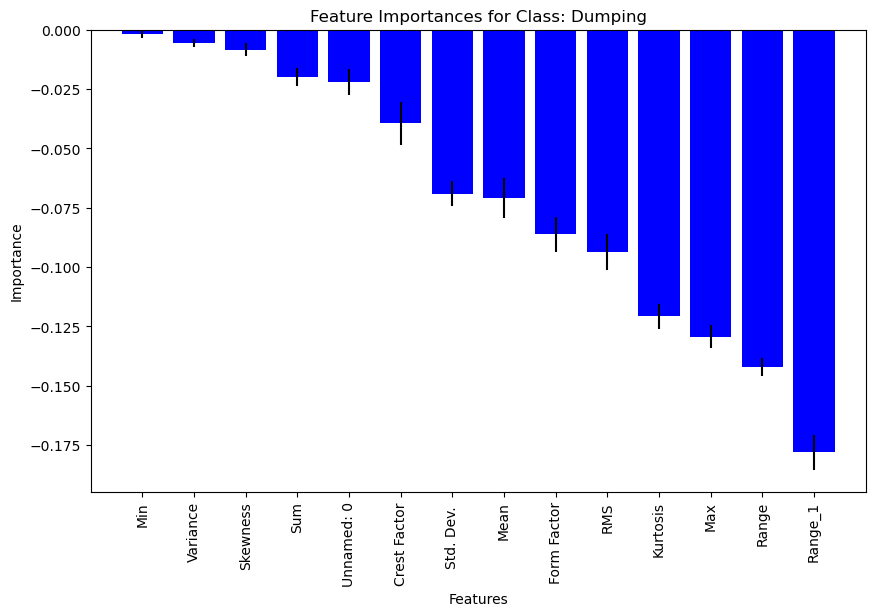

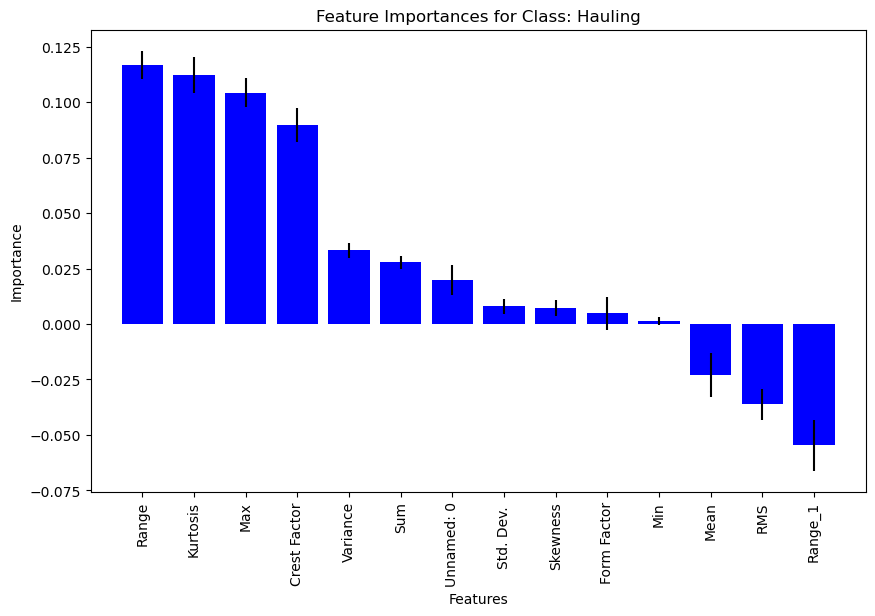

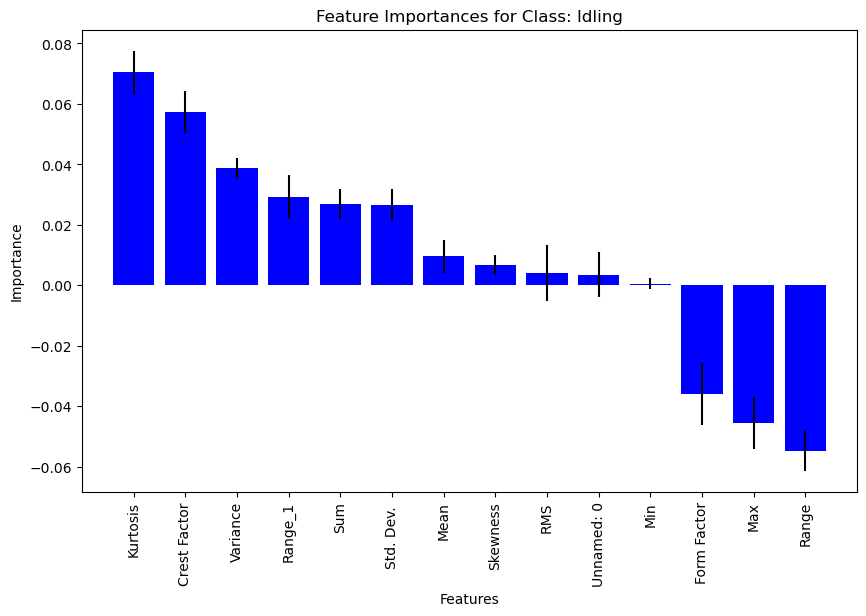

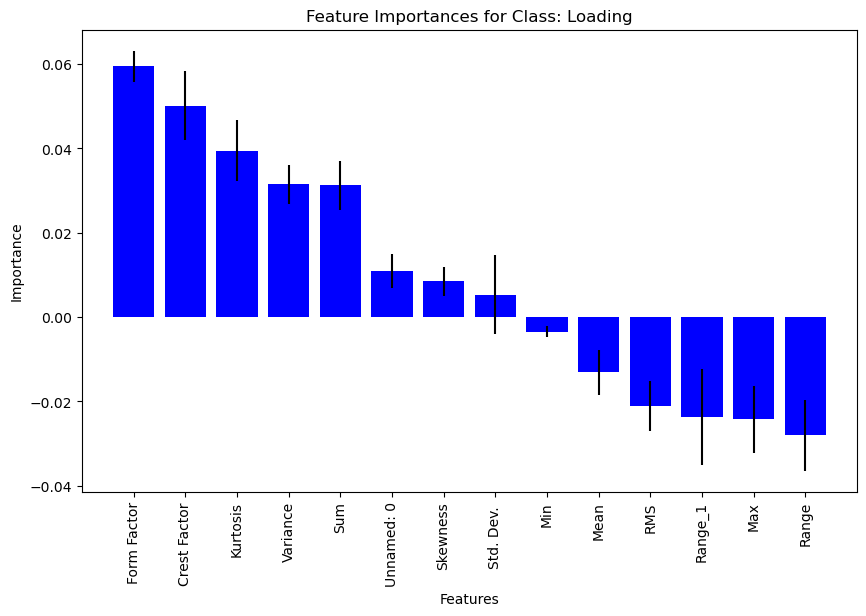

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, keras_model, classes):
        self.keras_model = keras_model
        self.classes_ = classes

    def fit(self, X, y):
        # This method won't actually train the model; it's just a placeholder
        return self

    def predict(self, X):
        y_pred_one_hot = self.keras_model.predict(X)
        return np.argmax(y_pred_one_hot, axis=1)

    def predict_proba(self, X):
        return self.keras_model.predict(X)

# Wrap the trained Keras model and pass the classes
wrapped_classifier = KerasClassifierWrapper(classifier, label_encoder.classes_)

# Function to calculate feature importance for each class
def calculate_feature_importance_per_class(wrapped_model, X_test, y_test, class_index):
    y_test_class = (y_test == class_index).astype(int)
    result = permutation_importance(wrapped_model, X_test, y_test_class, scoring='accuracy')
    return result

# Calculate feature importance for each class
feature_names = train_data.columns[:14]
class_importances = {}

for i, class_label in enumerate(label_encoder.classes_):
    result = calculate_feature_importance_per_class(wrapped_classifier, X_test, y_test_encoded, i)
    importances = result.importances_mean
    std_devs = result.importances_std
    
    class_importances[class_label] = {
        'importances': importances,
        'std_devs': std_devs
    }

    print(f"\nFeature importances for class {class_label}:")
    for idx in importances.argsort()[::-1]:
        print(f"{feature_names[idx]:<8} importance: {importances[idx]:.3f} +/- {std_devs[idx]:.3f}")

# Plotting the feature importances for each class
for class_label, importances_info in class_importances.items():
    importances = importances_info['importances']
    std_devs = importances_info['std_devs']
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances for Class: {class_label}")
    plt.bar(range(len(importances)), importances[indices], color="b", yerr=std_devs[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[idx] for idx in indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.show()


In [23]:
import matplotlib.pyplot as plt

# Number of classes
num_classes = len(class_importances)
# Determine the grid size for the subplots
grid_size = int(np.ceil(np.sqrt(num_classes)))

# Create a figure with a grid of subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each class's feature importances in a subplot
for idx, (class_label, importances_info) in enumerate(class_importances.items()):
    importances = importances_info['importances']
    std_devs = importances_info['std_devs']
    indices = np.argsort(importances)[::-1]

    axes[idx].bar(range(len(importances)), importances[indices], color="b", yerr=std_devs[indices], align="center")
    axes[idx].set_title(f"Class: {class_label}")
    axes[idx].set_xticks(range(len(importances)))
    axes[idx].set_xticklabels([feature_names[i] for i in indices], rotation=90)
    axes[idx].set_xlim([-1, len(importances)])
    axes[idx].set_xlabel("Features")
    axes[idx].set_ylabel("Importance")

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.savefig("feature_importances_collage.png")
plt.close()
